In [30]:
import torch, torchvision
import torchvision.transforms as T
from torchvision.models.detection import MaskRCNN
from PIL import Image, ImageDraw, ImageFont
import numpy as np
import requests
from io import BytesIO
import matplotlib.pyplot as plt
import cv2
import random

In [2]:
#List of COCO class names
COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter',
    'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra',
    'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis',
    'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard',
    'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon',
    'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'dining table', 'toilet',
    'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
    'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier',
    'toothbrush'
]

In [3]:
model= torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
model.eval()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth
100%|██████████| 170M/170M [00:01<00:00, 122MB/s]


MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(in

In [16]:
# Function to get a prediction
def get_prediction(img_path, threshold):
  img=Image.open(img_path).convert('RGB')
  transform=T.Compose([T.ToTensor()])
  img=transform(img)
  pred=model([img])
  pred_score=list(pred[0]['scores'].detach().numpy())
  pred_t= [pred_score.index(x) for x in pred_score if x> threshold][-1]
  masks=(pred[0]['masks']>0.5).squeeze().detach().cpu().numpy()
  pred_class=[COCO_INSTANCE_CATEGORY_NAMES[i] for i in list(pred[0]['labels'].numpy())]
  pred_boxes=[[(i[0], i[1]), (i[2], i[3])] for i in list(pred[0]['boxes'].detach().numpy())]
  masks=masks[:pred_t+1]
  pred_boxes=pred_boxes[:pred_t+1]
  pred_class=pred_class[:pred_t+1]
  return masks, pred_boxes, pred_class

In [17]:
img_path='horse.png'
masks,pred_boxes, pred_class=get_prediction(img_path, 0.5)

In [18]:
pred_class

['sheep']

In [19]:
pred_boxes

[[(54.073166, 28.933414), (336.5843, 334.42767)]]

In [20]:
masks[0].shape

(360, 360)

In [22]:
img=plt.imread('horse.png')

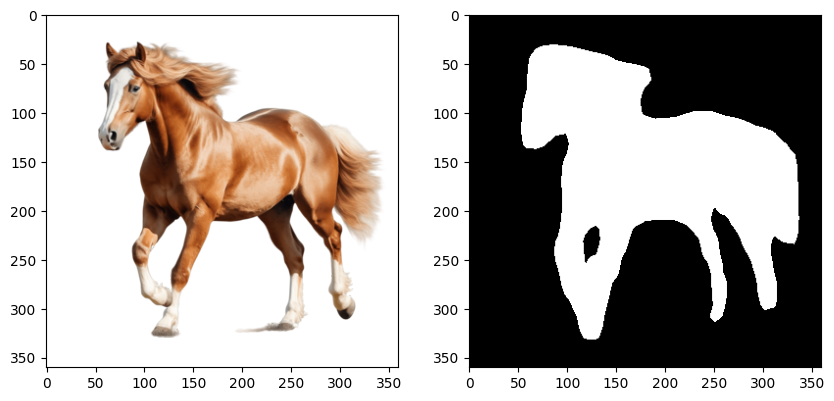

In [24]:
plt.figure(figsize=(10,10))
plt.subplot(121)
plt.imshow(img)
plt.subplot(122)
plt.imshow(masks[0], cmap='gray')

In [31]:
def random_color_masks(image):
  colours=[[0,255,0],[0,0,255],[255,0,0],[0,255,255],[255,255,0],
          [255,0,255],[80,70,180],[250,80,190],[245,145,50],
           [70,150,250],[50,190,190]]
  r=np.zeros_like(image).astype(np.uint8)
  g=np.zeros_like(image).astype(np.uint8)
  b=np.zeros_like(image).astype(np.uint8)
  r[image==1],g[image==1],b[image==1]=colours[random.randrange(0,10)]
  coloured_mask=np.stack([r,g,b],axis=2)
  return coloured_mask


In [36]:
def find_masks(img_path,threshold=0.5):
  masks,boxes,pred_cls= get_prediction(img_path,threshold)
  img=cv2.imread(img_path)
  img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  for i in range(len(masks)):
    rgb_mask=random_color_masks(masks[i])
    img=cv2.addWeighted(img,1,rgb_mask,0.5,0)
  plt.figure(figsize=(12,9))
  plt.imshow(img)

In [37]:
# Function to draw bounding boxes
def draw_boxes(img_path, threshold=0.5):
  boxes, pred_cls = get_prediction(img_path, threshold)
  img = Image.open(img_path)
  draw = ImageDraw.Draw(img)
  for box, cls in zip(boxes, pred_cls):
    draw.rectangle(box, outline='red', width=3)
    draw.text(box[0], cls, fill='black', stroke_width=5)
  return img

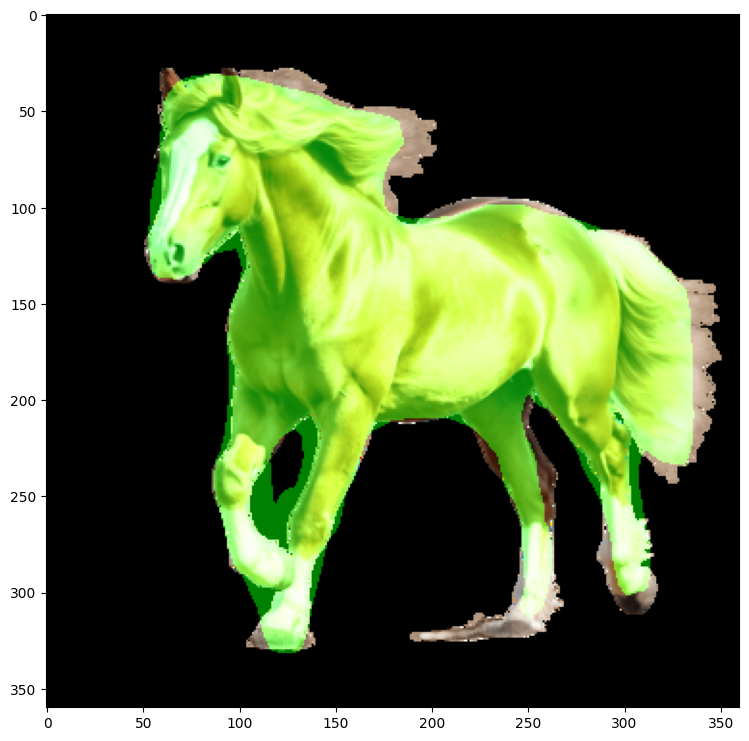

In [40]:
find_masks('horse.png')